In [1]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D, BatchNormalization, Dropout, Activation, MaxPool2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy as np
import os
from sklearn.utils import shuffle
import keras
from keras.callbacks import ReduceLROnPlateau
import math
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras import regularizers
from keras.utils import to_categorical
from sklearn.externals import joblib 
from sklearn.model_selection import train_test_split
from keras.models import load_model
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import RMSprop
import cv2
from face_rec import Image_Preprocessing
from pathlib import Path

Using TensorFlow backend.
C:\Users\ultra\Anaconda3\envs\ocr_env\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# [model load](https://keras.io/applications/#mobilenetv2)

# [mobileNet transfer learning](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e)
- from keras.applications import MobileNet
- from keras.applications.mobilenet import preprocess_input
## load layer
- `include_top`을 False로 하면 마지막 레이어 안가지고오고 True하면 마지막 레이어까지 가지고 옴
- 미리 훈련된 가중치를 사용하기 위해 `weights='imagenet'`
    - layer.trainable = False를 통해 조정못하게 함

In [2]:
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.layers import Dense,GlobalAveragePooling2D

In [16]:
base_model=MobileNet(input_shape=(128,128,3), weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

In [18]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

In [32]:
base_model.output.shape

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(1024)])

# input data(얼굴 이미지 같은/다른 쌍 의 np.array) load

In [3]:
data = np.load('./128_real_cnn_np.npz')
np_1 = data['x_data1']
np_2 = data['x_data2']
y_data = data['y_data']
print("np_1.shape : {} np_2.shape: {}, y_data.shape : {}".format(np_1.shape, np_2.shape, y_data.shape))
# 200 shape np array
# data = np.load('./128_real_cnn_np.npz')
# np_1 = data['x_data1']
# np_2 = data['x_data2']
# y_data = data['y_data']
# print("np_1.shape : {} np_2.shape: {}, y_data.shape : {}".format(np_1.shape, np_2.shape, y_data.shape))

np_1.shape : (1524, 128, 128, 3) np_2.shape: (1524, 128, 128, 3), y_data.shape : (1524,)


In [4]:
np_1 = np_1.astype('int32')
np_2 = np_2.astype('int32')

## train / validation data 8:2 각 train data는 =/255 로 normalization

In [5]:
x1_train, x1_val, x2_train, x2_val, y_train, y_val = train_test_split(np_1, np_2, y_data, test_size = 0.2, random_state = 5)
print("x1_train.shape : {}\nx1_val.shape : {}\nx2_train.shape : {}\nx2_val.shape : {} ".format(x1_train.shape, x1_val.shape, x2_train.shape, x2_val.shape))
print("y_train.shape : {}\ny_val.shape : {}".format(y_train.shape, y_val.shape))
# x1_train /= 255
# x1_val /= 255
# x2_train /= 255
# x2_val /= 255

x1_train.shape : (1219, 128, 128, 3)
x1_val.shape : (305, 128, 128, 3)
x2_train.shape : (1219, 128, 128, 3)
x2_val.shape : (305, 128, 128, 3) 
y_train.shape : (1219,)
y_val.shape : (305,)


# build one-shot model - MobileNetv2

In [6]:
def load_mobilenet():
    # 마지막 레이어 빼고 불러옴
    base_model=MobileNet(input_shape=(128,128,3), weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
    trainable_check = len(base_model.layers)
    # default trainable은 True임
    return base_model, trainable_check

In [7]:
def create_cnn_base():
    base_model, check_layer = load_mobilenet()
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256)(x) 
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128)(x) 
    x = BatchNormalization(axis=-1)(x)
    pred = Activation('sigmoid')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(1024)(x) 
#     x = BatchNormalization(axis=-1)(x)
#     x = Activation('relu')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(512)(x) 
#     x = BatchNormalization(axis=-1)(x)
#     x = Activation('relu')(x)   
#     x = Dropout(0.1)(x)
#     x = Dense(128)(x) 
#     x = BatchNormalization(axis=-1)(x)
#     pred = Activation('relu')(x)   
    model = Model(inputs=base_model.input, outputs=pred)
    for layer in model.layers[:check_layer]:
        layer.trainable = True
    # 마지막 추가한 dense layer에 대해서는 새로 학습되도록 함
    for layer in model.layers[check_layer:]:
        layer.trainable = True
    return model

def euclidean_distance(tensor_obj):
    x = tensor_obj[0]
    y = tensor_obj[1]
#   square_sum = K.sum(K.square(x - y), axis = 0)
#     return K.abs(x - y)
    return K.sqrt(K.square(x - y))
#     sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
#     return K.sqrt(K.maximum(sum_square, K.epsilon()))

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [ ]:
x = keras.layers.concatenate([lstm_out, auxiliary_input])

In [33]:
print(f'left_input : {left_input}')
print(f'right_input : {right_input}')
print(f'encoded_l : {encoded_l}')
print(f'encoded_r : {encoded_r}')
print(f'L1_distance : {L1_distance}')
print(f'prediction : {prediction}')

left_input : Tensor("input_1:0", shape=(?, 128, 128, 3), dtype=float32)
right_input : Tensor("input_2:0", shape=(?, 128, 128, 3), dtype=float32)
encoded_l : Tensor("model_1/activation_2/Sigmoid:0", shape=(?, 128), dtype=float32)
encoded_r : Tensor("model_1_1/activation_2/Sigmoid:0", shape=(?, 128), dtype=float32)
L1_distance : Tensor("lambda_1/Abs:0", shape=(?, 128), dtype=float32)
prediction : Tensor("dense_5/Sigmoid:0", shape=(?, 1), dtype=float32)


In [8]:
input_shape = (128, 128, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

#call the convnet Sequential model on each of the input tensors so params will be shared
cnn_base = create_cnn_base()
# encoded_l= Model(left_input, cnn_base(left_input))
# encoded_r = Model(right_input, cnn_base(right_input))
encoded_l = cnn_base(left_input)
encoded_r = cnn_base(right_input)
#layer to merge two encoded inputs with the l1 distance between them
# 임의의 표현식을 Layer객체로 래핑(여기선 CNN거치고 나온 각 이미지가 서로의 차를 송출하는 layer를 만듬)
# keras는 tensorflow의텐서 곱셈이라든지 같은 저수준 연산을 처리하지 않음
# 하지만 keras의 backend를 통해 tensorflow의 연산을 수행할 수 있음(여기선 텐서간 차를 구하고 절대값)

#call this layer on list of two input tensors.
#print('encdoe_L : {} \nencdoe_R : {}'.format(encoded_l.shape, encoded_r.shape))
L1_distance = Lambda(euclidean_distance)([encoded_l, encoded_r])
#add_dense = Dense(84, activation='relu',kernel_regularizer=l2(1e-3),kernel_initializer='he_normal',bias_initializer='he_normal')(L1_distance)
# prediction = Dense(1,activation='sigmoid',bias_initializer='he_normal')(L1_distance)
prediction = Dense(512,activation='relu',bias_initializer='he_normal')(L1_distance)
prediction = Dropout(0.1)(prediction)
prediction = Dense(256,activation='relu',bias_initializer='he_normal')(prediction)
prediction = Dropout(0.1)(prediction)
prediction = Dense(1,activation='sigmoid',bias_initializer='he_normal')(prediction)
print('L1_distance : {}'.format(L1_distance.shape))
# prediction =  BatchNormalization(axis=-1)(Activation(activation='sigmoid')(Dense(1,bias_initializer='he_normal')(L1_distance)))
# print('prediction : {}'.format(prediction))
# siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
print('siamese_net : {}'.format(siamese_net))

opt_adam = Adam(0.00006)
opt_sgd = SGD(lr=0.0001)
rms = RMSprop()
# 5epoch 지났을때마다 loss를 보고 learning rate를 0.1배로 높이거나 낮추는데 min_lr는 0.00001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
#optimzer = keras.optimizers.SGD(lr=0.0001)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss='binary_crossentropy',optimizer=opt_adam, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
L1_distance : (?, 128)
siamese_net : <keras.engine.training.Model object at 0x000001DCF1C4B160>


In [10]:
cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

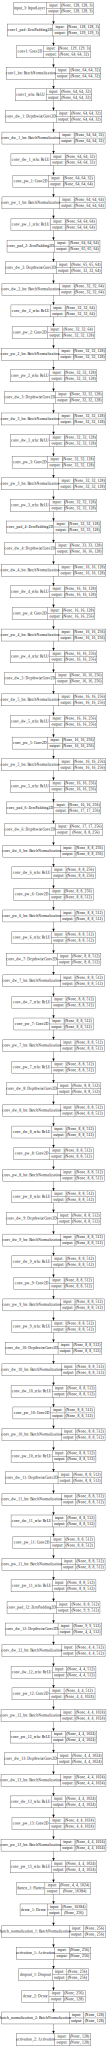

In [11]:
SVG(model_to_dot(cnn_base, show_shapes=True).create(prog='dot', format='svg'))

In [12]:
siamese_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          7457856     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128)          0           model_1[1][0]                    
          

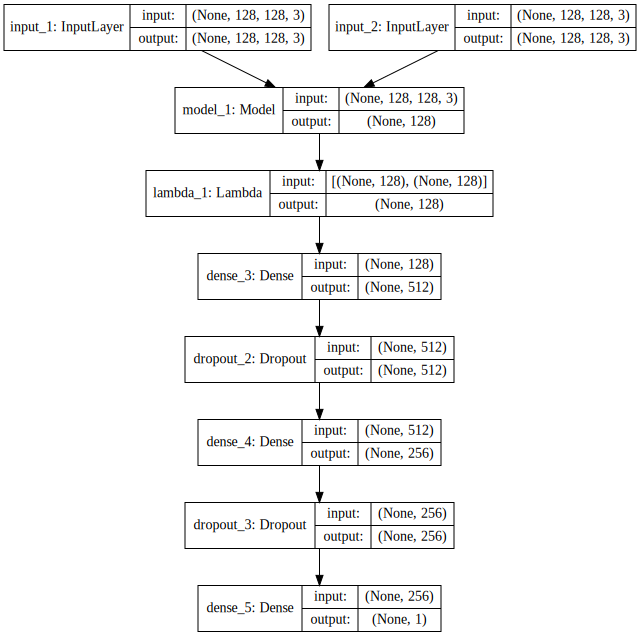

In [13]:
SVG(model_to_dot(siamese_net, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
input_data = [x1_train, x2_train]
val_data = ([x1_val, x2_val], y_val)

log = siamese_net.fit(input_data, y_train, epochs = 30, batch_size = 16, validation_data= val_data, callbacks=[reduce_lr])
#log = siamese_net.fit(input_data, y_train, epochs = 150, batch_size = 8, validation_data= val_data)

Instructions for updating:
Use tf.cast instead.
Train on 1219 samples, validate on 305 samples
Epoch 1/30
1219/1219 [==============================] - 45s 37ms/step - loss: 0.7331 - acc: 0.4979 - val_loss: 0.6974 - val_acc: 0.4656
Epoch 2/30
1219/1219 [==============================] - 30s 24ms/step - loss: 0.6765 - acc: 0.5677 - val_loss: 0.6770 - val_acc: 0.6066
Epoch 3/30
1219/1219 [==============================] - 30s 24ms/step - loss: 0.6446 - acc: 0.6866 - val_loss: 0.6539 - val_acc: 0.5967
Epoch 4/30
1219/1219 [==============================] - 29s 24ms/step - loss: 0.5836 - acc: 0.7957 - val_loss: 0.5703 - val_acc: 0.7705
Epoch 5/30
1219/1219 [==============================] - 30s 24ms/step - loss: 0.4838 - acc: 0.8811 - val_loss: 0.4486 - val_acc: 0.8492
Epoch 6/30
1219/1219 [==============================] - 30s 24ms/step - loss: 0.3369 - acc: 0.9467 - val_loss: 0.2938 - val_acc: 0.9246
Epoch 7/30
1219/1219 [==============================] - 29s 24ms/step - loss: 0.2092 - ac

## MobileNet Siamese save

In [11]:
siamese_net.save('./16batch.h5')

## MobileNet Siamese load

In [4]:
mobilesiamese = load_model('./16batch.h5')

In [5]:
mobilesiamese.summaryary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          7457856     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128)          0           model_1[1][0]                    
          

## MobileNet Siamese test

In [7]:
%%time
# image를 resize해주고 reshape.. 인자로 size를 줘야함
def resize_reshape_img(img_path, img_size):
    img = cv2.resize(cv2.imread(img_path),(img_size,img_size))
    return img.reshape([-1, img_size, img_size, 3])

img_path = './small_traiging_images3/'
#original_img_path = './small_traiging_images2/finn_10_extend/finn_3_box.jpg'
original_img_path = './small_traiging_images2/emma_10_extend/hermi_10_box.jpg'
# original img <- 들어오는 이미지 shape과 size를 바꿔줌
original_img = resize_reshape_img(original_img_path, 128)

acc_list = []
file_list = []
# 전체경로에서 각 이미지 폴더에 접근
for folder in os.listdir(img_path):
    folder_path = os.path.join(img_path, folder)
    # 각 이미지 폴더에서 폴더내 이미지 접근
    for file in os.listdir(folder_path):
        
        file_path = os.path.join(folder_path, file)
        # db폴더내의 각 이미지에 대해 resize , reshape
        compare_file = resize_reshape_img(file_path, 128)
        file_list.append(file_path)
        matching = mobilesiamese.predict([original_img, compare_file])[0]
        print("{} predict... matching : {}".format(file, matching))
        acc_list.append(matching)
acc_np = np.array(acc_list)        
max_idx = np.argmax(acc_np)

wr_list = {}
max_list = np.argsort(acc_np, axis = 0)[::-1]
for idx in max_list[:10]:
    print(file_list[idx[0]], acc_np[idx])
    identity = Path(file_list[idx[0]]).parent
    identity = str.split(str(identity), '\\')[-1]
    try: wr_list[identity] += 1
    except: wr_list[identity]=1
print('*'* 50)
matching_folder = [keys for keys, values in wr_list.items() if values == max(wr_list.values())][0]
print('matching folder : {}'.format(matching_folder))
print('file name : {}, acc : {}'.format(file_list[max_idx], acc_np[max_idx]))

donald_glover_10_box.jpg predict... matching : [0.00026268]
donald_glover_1_box.jpg predict... matching : [0.00017877]
donald_glover_2_box.jpg predict... matching : [0.00076434]
donald_glover_3_box.jpg predict... matching : [0.000191]
donald_glover_4_box.jpg predict... matching : [0.00269872]
donald_glover_5_box.jpg predict... matching : [0.00047542]
donald_glover_6_box.jpg predict... matching : [0.00127284]
donald_glover_7_box.jpg predict... matching : [0.00104014]
donald_glover_8_box.jpg predict... matching : [0.00061218]
donald_glover_9_box.jpg predict... matching : [0.00032476]
hermi_10_box.jpg predict... matching : [0.9891916]
hermi_1_box.jpg predict... matching : [0.99748695]
hermi_2_box.jpg predict... matching : [0.9996735]
hermi_3_box.jpg predict... matching : [0.9996828]
hermi_4_box.jpg predict... matching : [0.99911827]
hermi_5_box.jpg predict... matching : [0.99280953]
hermi_6_box.jpg predict... matching : [0.9994716]
hermi_7_box.jpg predict... matching : [0.99801207]
hermi_

wang3_box.jpg predict... matching : [7.001828e-06]
wang4_box.jpg predict... matching : [3.2209282e-06]
wang5_box.jpg predict... matching : [2.062822e-06]
wang6_box.jpg predict... matching : [2.609476e-06]
wang7_box.jpg predict... matching : [4.2011524e-07]
wang8_box.jpg predict... matching : [1.0253224e-06]
wang9_box.jpg predict... matching : [4.4782587e-06]
./small_traiging_images3/emma_10_facebox\hermi_9_box.jpg [[0.99986756]]
./small_traiging_images3/emma_10_facebox\hermi_3_box.jpg [[0.9996828]]
./small_traiging_images3/emma_10_facebox\hermi_2_box.jpg [[0.9996735]]
./small_traiging_images3/emma_10_facebox\hermi_6_box.jpg [[0.9994716]]
./small_traiging_images3/emma_10_facebox\hermi_8_box.jpg [[0.99926394]]
./small_traiging_images3/emma_10_facebox\hermi_4_box.jpg [[0.99911827]]
./small_traiging_images3/emma_10_facebox\hermi_7_box.jpg [[0.99801207]]
./small_traiging_images3/emma_10_facebox\hermi_1_box.jpg [[0.99748695]]
./small_traiging_images3/emma_10_facebox\hermi_5_box.jpg [[0.99280

# MNIST SimaeseNet KERAS

In [19]:
def euclidean_distance(tensor_obj):
    x = tensor_obj[0]
    y = tensor_obj[1]
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

input_shape = (128, 128, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

#call the convnet Sequential model on each of the input tensors so params will be shared
cnn_base = create_cnn_base()
# encoded_l= Model(left_input, cnn_base(left_input))
# encoded_r = Model(right_input, cnn_base(right_input))
encoded_l = cnn_base(left_input)
encoded_r = cnn_base(right_input)
#layer to merge two encoded inputs with the l1 distance between them
# 임의의 표현식을 Layer객체로 래핑(여기선 CNN거치고 나온 각 이미지가 서로의 차를 송출하는 layer를 만듬)
# keras는 tensorflow의텐서 곱셈이라든지 같은 저수준 연산을 처리하지 않음
# 하지만 keras의 backend를 통해 tensorflow의 연산을 수행할 수 있음(여기선 텐서간 차를 구하고 절대값)

#call this layer on list of two input tensors.
#print('encdoe_L : {} \nencdoe_R : {}'.format(encoded_l.shape, encoded_r.shape))
L1_distance = Lambda(euclidean_distance)([encoded_l, encoded_r])
#add_dense = Dense(84, activation='relu',kernel_regularizer=l2(1e-3),kernel_initializer='he_normal',bias_initializer='he_normal')(L1_distance)
#prediction = Dense(1,activation='sigmoid',bias_initializer='he_normal')(L1_distance)
print('L1_distance : {}'.format(L1_distance.shape))
prediction =  BatchNormalization(axis=-1)(Activation(activation='sigmoid')(Dense(1,bias_initializer='he_normal')(L1_distance)))
print('prediction : {}'.format(prediction))
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
print('siamese_net : {}'.format(siamese_net))

opt_adam = Adam(0.00006)
opt_sgd = SGD(lr=0.001)
rms = RMSprop()
# 5epoch 지났을때마다 loss를 보고 learning rate를 0.1배로 높이거나 낮추는데 min_lr는 0.00001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
#optimzer = keras.optimizers.SGD(lr=0.0001)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss=contrastive_loss,optimizer=rms, metrics=[accuracy])

L1_distance : (?, 1)
prediction : Tensor("batch_normalization_4/cond/Merge:0", shape=(?, 1), dtype=float32)
siamese_net : <keras.engine.training.Model object at 0x000002543F9A2940>


# Kaggle SiameseNet

In [23]:
# We have 2 inputs, 1 for each picture
left_input = Input((128,128,3))
right_input = Input((128,128,3))

# We will use 2 instances of 1 network for this task
convnet = Sequential([
    Conv2D(5,3, input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(5,3),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    Flatten(),
    Dense(18),
    Activation('sigmoid')
])
# Connect each 'leg' of the network to each input
# Remember, they have the same weights
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# Getting the L1 Distance between the 2 encodings
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

# Add the distance function to the network
L1_distance = L1_layer([encoded_l, encoded_r])

prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.001, decay=2.5e-4)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

In [ ]:



# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

In [ ]:
def create_cnn_base(input_shape):
    base_model = load_mobilenet
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x) 
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Dense(256)(x) 
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Dense(128)(x) 
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Dense(64)(x) 
    x = BatchNormalization(axis=-1)(x)
    pred = Activation('sigmoid')(x)    
    
    convnet = Sequential()
    # weight와 bias에 대해서 he_normal로 초기화시키도록 함
    convnet.add(Conv2D(18,(7,7), input_shape=input_shape,
                       kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    return convnet
    
def euclidean_distance(tensor_obj):
    x = tensor_obj[0]
    y = tensor_obj[1]
    #square_sum = K.sum(K.square(x - y), axis = 0)
    return K.abs(x - y)
    
# def contrastive_loss(y_true, y_pred):
#     margin = 1
#     sqaure_pred = K.square(y_pred)
#     margin_square = K.square(K.maximum(margin - y_pred, 0))
#     return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

# def accuracy(y_true, y_pred):
    
#     return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


input_shape = (128, 128, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

#call the convnet Sequential model on each of the input tensors so params will be shared
cnn_base = create_cnn_base(input_shape)
encoded_l = cnn_base(left_input)
encoded_r = cnn_base(right_input)
#layer to merge two encoded inputs with the l1 distance between them
# 임의의 표현식을 Layer객체로 래핑(여기선 CNN거치고 나온 각 이미지가 서로의 차를 송출하는 layer를 만듬)
# keras는 tensorflow의텐서 곱셈이라든지 같은 저수준 연산을 처리하지 않음
# 하지만 keras의 backend를 통해 tensorflow의 연산을 수행할 수 있음(여기선 텐서간 차를 구하고 절대값)

 #call this layer on list of two input tensors.
print('encdoe_L : {} \nencdoe_R : {}'.format(encoded_l.shape, encoded_r.shape))
L1_distance = Lambda(euclidean_distance)([encoded_l, encoded_r])
#add_dense = Dense(84, activation='relu',kernel_regularizer=l2(1e-3),kernel_initializer='he_normal',bias_initializer='he_normal')(L1_distance)
#prediction = Dense(1,activation='sigmoid',bias_initializer='he_normal')(L1_distance)
print('L1_distance : {}'.format(L1_distance.shape))
prediction =  BatchNormalization(axis=-1)(Activation(activation='sigmoid')(Dense(1,bias_initializer='he_normal')(L1_distance)))
print('prediction : {}'.format(prediction))
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
print('siamese_net : {}'.format(siamese_net))

opt_adam = Adam(0.0001)
opt_sgd = SGD(lr=0.0001)
rms = RMSprop()
# 5epoch 지났을때마다 loss를 보고 learning rate를 0.1배로 높이거나 낮추는데 min_lr는 0.00001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
#optimzer = keras.optimizers.SGD(lr=0.0001)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss='binary_crossentropy',optimizer=opt_adam, metrics=['accuracy'])


# build one shot model

In [134]:
def create_cnn_base(input_shape):
    convnet = Sequential()
    # weight와 bias에 대해서 he_normal로 초기화시키도록 함
    convnet.add(Conv2D(18,(7,7), input_shape=input_shape,
                       kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    # 비선형 activation 전에 batchnormalization을 해줌
    # Internal Covariance Shift라는 현상은 Network의 각 층이나 Activation 마다 input의 distribution이 달라지는 현상을 의미
    # 이를 방지하기 위해 batch normalization
    convnet.add(BatchNormalization(axis = -1))
    convnet.add(Activation('relu'))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.1))

    convnet.add(Conv2D(12,(5,5), kernel_regularizer=regularizers.l2(0.01),
                       kernel_initializer='he_normal'))
    convnet.add(BatchNormalization(axis = -1))
    convnet.add(Activation('relu'))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.1))
    
    convnet.add(Conv2D(16,(4,4), kernel_initializer='he_normal',
                       kernel_regularizer=regularizers.l2(0.01)))
    convnet.add(BatchNormalization(axis = -1))
    convnet.add(Activation('relu'))
    convnet.add(Dropout(0.1))
    
    convnet.add(Conv2D(32,(3,3), kernel_initializer='he_normal',
                       kernel_regularizer=regularizers.l2(0.01)))
    convnet.add(BatchNormalization(axis = -1))
    convnet.add(Activation('relu'))
    convnet.add(MaxPooling2D())
    
    

    convnet.add(Flatten())
    
    
    convnet.add(Dense(512, kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_normal', bias_initializer='he_normal'))
    convnet.add(BatchNormalization(axis = -1))
    convnet.add(Activation('sigmoid'))    
    convnet.add(Dropout(0.1))
    
    convnet.add(Dense(128, kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_normal', bias_initializer='he_normal'))
    convnet.add(BatchNormalization(axis = -1))
    convnet.add(Activation('sigmoid'))    
    convnet.add(Dropout(0.1))
    
    convnet.add(Dense(48, kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_normal', bias_initializer='he_normal'))
    convnet.add(BatchNormalization(axis = -1))
    convnet.add(Activation('sigmoid'))    
    return convnet
    
def euclidean_distance(tensor_obj):
    x = tensor_obj[0]
    y = tensor_obj[1]
    #square_sum = K.sum(K.square(x - y), axis = 0)
    return K.abs(x - y)
    
# def contrastive_loss(y_true, y_pred):
#     margin = 1
#     sqaure_pred = K.square(y_pred)
#     margin_square = K.square(K.maximum(margin - y_pred, 0))
#     return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

# def accuracy(y_true, y_pred):
    
#     return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


input_shape = (128, 128, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

#call the convnet Sequential model on each of the input tensors so params will be shared
cnn_base = create_cnn_base(input_shape)
encoded_l = cnn_base(left_input)
encoded_r = cnn_base(right_input)
#layer to merge two encoded inputs with the l1 distance between them
# 임의의 표현식을 Layer객체로 래핑(여기선 CNN거치고 나온 각 이미지가 서로의 차를 송출하는 layer를 만듬)
# keras는 tensorflow의텐서 곱셈이라든지 같은 저수준 연산을 처리하지 않음
# 하지만 keras의 backend를 통해 tensorflow의 연산을 수행할 수 있음(여기선 텐서간 차를 구하고 절대값)

 #call this layer on list of two input tensors.
print('encdoe_L : {} \nencdoe_R : {}'.format(encoded_l.shape, encoded_r.shape))
L1_distance = Lambda(euclidean_distance)([encoded_l, encoded_r])
#add_dense = Dense(84, activation='relu',kernel_regularizer=l2(1e-3),kernel_initializer='he_normal',bias_initializer='he_normal')(L1_distance)
#prediction = Dense(1,activation='sigmoid',bias_initializer='he_normal')(L1_distance)
print('L1_distance : {}'.format(L1_distance.shape))
prediction =  BatchNormalization(axis=-1)(Activation(activation='sigmoid')(Dense(1,bias_initializer='he_normal')(L1_distance)))
print('prediction : {}'.format(prediction))
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
print('siamese_net : {}'.format(siamese_net))

opt_adam = Adam(0.0001)
opt_sgd = SGD(lr=0.0001)
rms = RMSprop()
# 5epoch 지났을때마다 loss를 보고 learning rate를 0.1배로 높이거나 낮추는데 min_lr는 0.00001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
#optimzer = keras.optimizers.SGD(lr=0.0001)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss='binary_crossentropy',optimizer=opt_adam, metrics=['accuracy'])


encdoe_L : (?, 48) 
encdoe_R : (?, 48)
L1_distance : (?, 48)
prediction : Tensor("batch_normalization_55/cond/Merge:0", shape=(?, 1), dtype=float32)
siamese_net : <keras.engine.training.Model object at 0x00000211AF420AC8>


In [5]:
siamese_net.summary(), siamese_net.input, siamese_net.output

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 48)           6644836     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 48)           0           sequential_1[1][0]               
          

(None,
 [<tf.Tensor 'input_1:0' shape=(?, 200, 200, 3) dtype=float32>,
  <tf.Tensor 'input_2:0' shape=(?, 200, 200, 3) dtype=float32>],
 <tf.Tensor 'batch_normalization_8/cond/Merge:0' shape=(?, 1) dtype=float32>)

# learning

In [6]:
input_data = [x1_train, x2_train]
val_data = [[x1_val, x2_val], y_val]

#log = siamese_net.fit(input_data, y_train, epochs = 3, batch_size = 1, validation_data= val_data, callbacks=[reduce_lr])
log = siamese_net.fit(input_data, y_train, epochs = 100, batch_size = 2, validation_data= val_data)

Instructions for updating:
Use tf.cast instead.
Train on 1219 samples, validate on 305 samples
Epoch 1/100
1219/1219 [==============================] - 150s 123ms/step - loss: 15.7549 - acc: 0.5086 - val_loss: 19.8344 - val_acc: 0.1836
Epoch 2/100
1219/1219 [==============================] - 144s 118ms/step - loss: 12.9474 - acc: 0.5086 - val_loss: 17.5064 - val_acc: 0.0820
Epoch 3/100
1219/1219 [==============================] - 144s 118ms/step - loss: 10.4247 - acc: 0.5086 - val_loss: 15.2645 - val_acc: 0.0492
Epoch 4/100
1219/1219 [==============================] - 144s 118ms/step - loss: 8.1629 - acc: 0.5086 - val_loss: 13.3216 - val_acc: 0.0689
Epoch 5/100
1219/1219 [==============================] - 144s 118ms/step - loss: 6.3228 - acc: 0.5086 - val_loss: 11.8345 - val_acc: 0.2131
Epoch 6/100
1219/1219 [==============================] - 144s 118ms/step - loss: 4.9498 - acc: 0.5086 - val_loss: 10.7755 - val_acc: 0.1115
Epoch 7/100
1219/1219 [==============================] - 144s 

KeyboardInterrupt: 

# loss view

In [20]:
def show_results(*logs):
    trn_loss, val_loss, trn_acc, val_acc = [],[],[],[]
    
    for log in logs:
        trn_loss += log.history['loss']
        val_loss += log.history['val_loss']
        
    fig, ax = plt.subplots(figsize = (8,4))
    # loss value
    ax.plot(trn_loss, label = 'train')
    # accuracy
    ax.plot(val_loss, label = 'validation')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend()

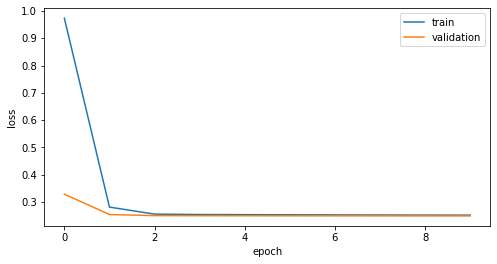

In [21]:
show_results(log)

# kears model view

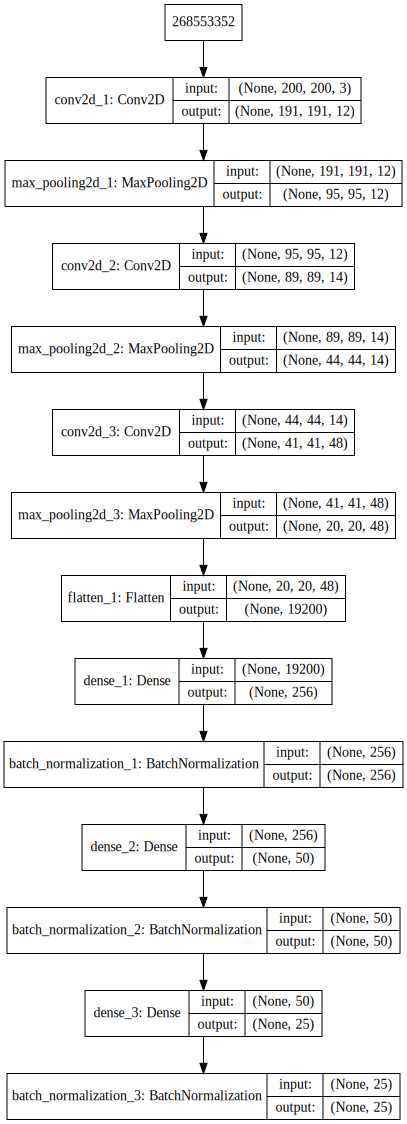

In [10]:
SVG(model_to_dot(cnn_base, show_shapes=True).create(prog='dot', format='svg'))

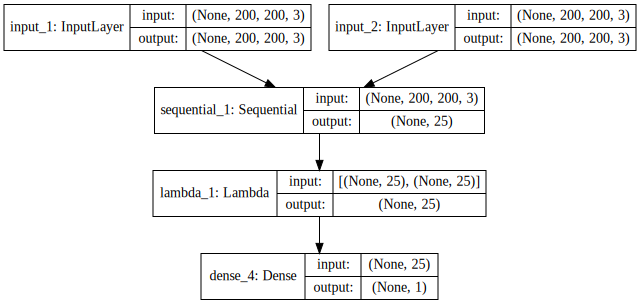

In [9]:
SVG(model_to_dot(siamese_net, show_shapes=True).create(prog='dot', format='svg'))

# model save

In [ ]:
# Returns a compiled model identical to the previous one
# model = load_model('./siamese_net_200_test.h5')

img_size = 200
origianl_img = cv2.resize(cv2.imread(ori_path), (img_size,img_size))

model.predict(([original_img, compared_img1]))

In [2]:
model = load_model('./siamese_net_200_3x3_simple_95.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# 가장 유사한 이미지 이름과 acc 리턴
- 가장 일치하는 상위 10개 중 많이 등장하는 이름을 같다고 봄

In [3]:
%%time
# image를 resize해주고 reshape.. 인자로 size를 줘야함
def resize_reshape_img(img_path, img_size):
    img = cv2.resize(cv2.imread(img_path),(img_size,img_size))
    return img.reshape([-1, img_size, img_size, 3])

img_path = './small_traiging_images3/'
#original_img_path = './small_traiging_images2/finn_10_extend/finn_3_box.jpg'
original_img_path = './small_traiging_images2/emma_10_extend/hermi_10_box.jpg'
# original img <- 들어오는 이미지 shape과 size를 바꿔줌
original_img = resize_reshape_img(original_img_path, 200)

acc_list = []
file_list = []
# 전체경로에서 각 이미지 폴더에 접근
for folder in os.listdir(img_path):
    folder_path = os.path.join(img_path, folder)
    # 각 이미지 폴더에서 폴더내 이미지 접근
    for file in os.listdir(folder_path):
        
        file_path = os.path.join(folder_path, file)
        # db폴더내의 각 이미지에 대해 resize , reshape
        compare_file = resize_reshape_img(file_path, 200)
        file_list.append(file_path)
        matching = model.predict([original_img, compare_file])[0]
        print("{} predict... matching : {}".format(file, matching))
        acc_list.append(matching)
acc_np = np.array(acc_list)        
max_idx = np.argmax(acc_np)

wr_list = {}
max_list = np.argsort(acc_np, axis = 0)[::-1]
for idx in max_list[:10]:
    print(file_list[idx[0]], acc_np[idx])
    identity = Path(file_list[idx[0]]).parent
    identity = str.split(str(identity), '\\')[-1]
    try: wr_list[identity] += 1
    except: wr_list[identity]=1
print('*'* 50)
matching_folder = [keys for keys, values in wr_list.items() if values == max(wr_list.values())][0]
print('matching folder : {}'.format(matching_folder))
print('file name : {}, acc : {}'.format(file_list[max_idx], acc_np[max_idx]))

donald_glover_10_box.jpg predict... matching : [0.06824947]
donald_glover_1_box.jpg predict... matching : [0.07148212]
donald_glover_2_box.jpg predict... matching : [0.08315767]
donald_glover_3_box.jpg predict... matching : [0.069424]
donald_glover_4_box.jpg predict... matching : [0.07252241]
donald_glover_5_box.jpg predict... matching : [0.07163048]
donald_glover_6_box.jpg predict... matching : [0.07071783]
donald_glover_7_box.jpg predict... matching : [0.06757205]
donald_glover_8_box.jpg predict... matching : [0.07203952]
donald_glover_9_box.jpg predict... matching : [0.08981802]
hermi_10_box.jpg predict... matching : [0.820778]
hermi_1_box.jpg predict... matching : [0.81840724]
hermi_2_box.jpg predict... matching : [0.81691235]
hermi_3_box.jpg predict... matching : [0.8207074]
hermi_4_box.jpg predict... matching : [0.8036664]
hermi_5_box.jpg predict... matching : [0.8210095]
hermi_6_box.jpg predict... matching : [0.82066244]
hermi_7_box.jpg predict... matching : [0.82124275]
hermi_8

wang5_box.jpg predict... matching : [0.13585329]
wang6_box.jpg predict... matching : [0.13460894]
wang7_box.jpg predict... matching : [0.13824083]
wang8_box.jpg predict... matching : [0.13403293]
wang9_box.jpg predict... matching : [0.13457295]
./small_traiging_images3/emma_10_facebox\hermi_7_box.jpg [[0.82124275]]
./small_traiging_images3/emma_10_facebox\hermi_5_box.jpg [[0.8210095]]
./small_traiging_images3/emma_10_facebox\hermi_10_box.jpg [[0.820778]]
./small_traiging_images3/emma_10_facebox\hermi_3_box.jpg [[0.8207074]]
./small_traiging_images3/emma_10_facebox\hermi_6_box.jpg [[0.82066244]]
./small_traiging_images3/emma_10_facebox\hermi_8_box.jpg [[0.8188771]]
./small_traiging_images3/emma_10_facebox\hermi_9_box.jpg [[0.8184234]]
./small_traiging_images3/emma_10_facebox\hermi_1_box.jpg [[0.81840724]]
./small_traiging_images3/finn_10_facebox\finn_7_box.jpg [[0.81756955]]
./small_traiging_images3/finn_10_facebox\finn_8_box.jpg [[0.8175381]]
*******************************************

In [8]:
%%time
ip = Image_Preprocessing()

# image를 resize해주고 reshape.. 인자로 size를 줘야함
def resize_reshape_img(img_path, img_size):
    img = cv2.resize(cv2.imread(img_path),(img_size,img_size))
    return img.reshape([-1, img_size, img_size, 3])

img_path = './small_traiging_images3/'
#original_img_path = './small_traiging_images2/finn_10_extend/finn_3_box.jpg'
original_img_path = './small_traiging_images2/emma_10_extend/hermi_10_box.jpg'
# original img <- 들어오는 이미지 shape과 size를 바꿔줌

original_img = ip.face_preprocessing(original_img_path)
original_img = cv2.resize(original_img, (200,200))
original_img = original_img.reshape([-1, 200,200, 3])

acc_list = []
file_list = []
# 전체경로에서 각 이미지 폴더에 접근
for folder in os.listdir(img_path):
    folder_path = os.path.join(img_path, folder)
    # 각 이미지 폴더에서 폴더내 이미지 접근
    for file in os.listdir(folder_path):
        
        file_path = os.path.join(folder_path, file)
        # db폴더내의 각 이미지에 대해 resize , reshape
        compare_file = resize_reshape_img(file_path, 200)
        file_list.append(file_path)
        matching = model.predict([original_img, compare_file])[0]
        print("{} predict... matching : {}".format(file, matching))
        acc_list.append(matching)
acc_np = np.array(acc_list)        
max_idx = np.argmax(acc_np)

wr_list = {}
max_list = np.argsort(acc_np, axis = 0)[::-1]
for idx in max_list[:10]:
    print(file_list[idx[0]], acc_np[idx])
    identity = Path(file_list[idx[0]]).parent
    identity = str.split(str(identity), '\\')[-1]
    try: wr_list[identity] += 1
    except: wr_list[identity]=1
print('*'* 50)
matching_folder = [keys for keys, values in wr_list.items() if values == max(wr_list.values())][0]
print('matching folder : {}'.format(matching_folder))
print('file name : {}, acc : {}'.format(file_list[max_idx], acc_np[max_idx]))

TypeError: Expected cv::UMat for argument 'src'